# 2.1.2 Related works
- In 2018, Pashaei et al. introduced the KE-CNN method, which achieved an impressive 93.68% accuracy rate by utilizing Convolutional Neural Networks (CNN) for feature extraction and Kernel Extreme Learning Machine (KELM) for classification. However, KE-CNN has the common limitations of CNN, relying on large datasets and potentially incurring high computational costs. Additionally, the authors did not employ dimension reduction techniques, which could have mitigated some of these computational challenges.
-  In 2023, Kurdi et al. introduced a meta-heuristic optimized CNN approach for brain tumor classification, demonstrating an impressive 98% accuracy rate. Notably, they utilized the same dataset as the current study but did not address the dataset's class imbalance issue. 

Pashaei, Ali, Hedieh Sajedi, and Niloofar Jazayeri. “Brain Tumor Classification via Convolutional Neural Network and Extreme Learning Machines.” 2018 8th International Conference on Computer and Knowledge Engineering (ICCKE), December 2018. https://doi.org/10.1109/iccke.2018.8566571.  
<br>
Kurdi, Sarah Zuhair, Mohammed Hasan Ali, Mustafa Musa Jaber, Tanzila Saba, Amjad Rehman, and Robertas Damaševičius. “Brain Tumor Classification Using Meta-Heuristic Optimized Convolutional Neural Networks.” Journal of Personalized Medicine 13, no. 2 (2023): 181. https://doi.org/10.3390/jpm13020181.  



In [ ]:
# 1. We will be doing dimensionality reduction with feature extraction
# 2. We augmented images and oversampled to address class imbalance issue

# Data Understanding / Processing / Feature Extraction Notebook

## Import Dependencies

In [ ]:
# %pip install opencv-python-headless
# %pip install pandas
# %pip install scikit-learn
# %pip install keras
# %pip install matplotlib
# %pip install numpy
# %pip install seaborn
# %pip install scikit-image


In [1]:
import cv2
import os
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# from keras_preprocessing.image import ImageDataGenerator,load_img, img_to_array
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from skimage.feature import hog

# 1. Exploratory Data Analysis (EDA)

## Read images

In [2]:
import os
import glob

# Specify the path to your main brain tumor folder
main_folder_path = "../Project/Brain_Tumor/data"

# Define the subfolders for benign and malignant tumors
benign_folder = os.path.join(main_folder_path, "benign")
malignant_folder = os.path.join(main_folder_path, "malignant")

# Function to count the number of image files in a folder
def count_images_in_folder(folder_path):
    image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.gif", "*.bmp"]  # Add more extensions if needed
    total_count = 0

    for ext in image_extensions:
        pattern = os.path.join(folder_path, ext)
        image_files = glob.glob(pattern)
        total_count += len(image_files)

    return total_count

# Count images in the benign and malignant folders
benign_count = count_images_in_folder(benign_folder)
malignant_count = count_images_in_folder(malignant_folder)

# Print the counts
print(f"Total number of benign tumor images: {benign_count}")
print(f"Total number of malignant tumor images: {malignant_count}")


Total number of benign tumor images: 77
Total number of malignant tumor images: 154


In [3]:
image_path = '../Project/Brain_Tumor/data/benign/1.jpg'
#Read image as Grayscale
image = cv2.imread(image_path,0)

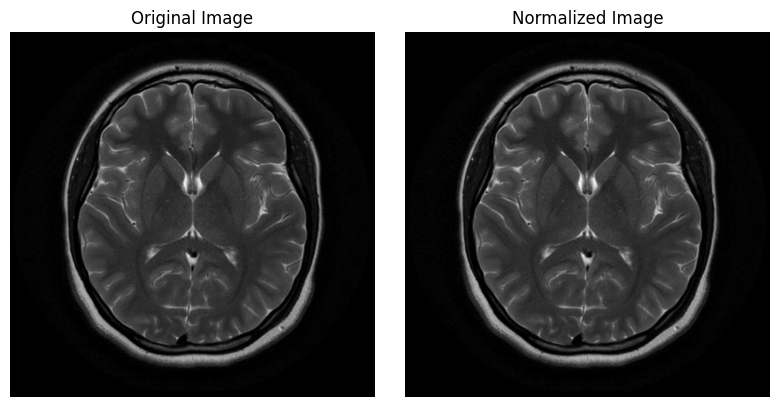

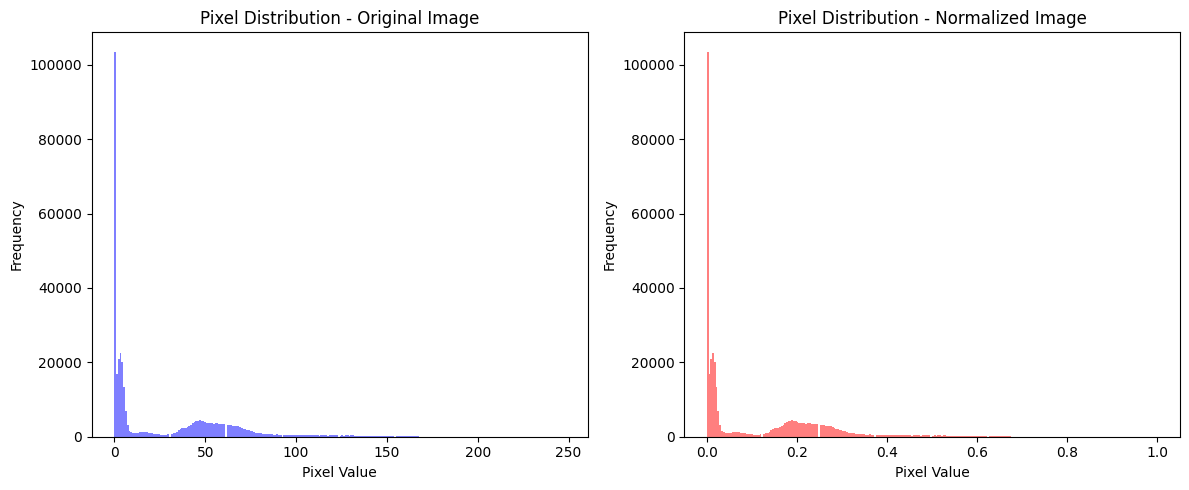

(630, 630)


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(image):
    # Convert image to floating point
    image_float = image.astype(float)

    # Find the minimum and maximum pixel values
    min_val = np.min(image_float.ravel())
    max_val = np.max(image_float.ravel())

    # Apply normalization
    normalized = (image_float - min_val) / (max_val - min_val)

    return normalized

normalized_image = normalize_image(image)

# Step 1: Display original and normalized images
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Normalized image
plt.subplot(1, 3, 2)
plt.title('Normalized Image')
# If the original image is grayscale, make sure we still plot it in grayscale
if len(normalized_image.shape) == 2:
    plt.imshow(normalized_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor((normalized_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 4: Plot the pixel distribution (histogram) for the original image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Pixel Distribution - Original Image')
plt.hist(image.ravel(), bins=256, color='blue', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Step 5: Plot the pixel distribution (histogram) for the normalized image
plt.subplot(1, 2, 2)
plt.title('Pixel Distribution - Normalized Image')
plt.hist(normalized_image.ravel(), bins=256, range=(0,1), color='red', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(normalized_image.shape)

#### Label encoding is a technique used to convert categorical labels into numerical values. 

In [6]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define the path to your main brain tumor folder
main_folder_path = "../Project/Brain_Tumor/data"

# Initialize an empty dictionary to store image filenames and categories
image_label_dict = {'image_filename': [], 'category': []}

# Iterate through the subfolders (benign and malignant) to collect image filenames and categories
for category in os.listdir(main_folder_path):
    category_folder = os.path.join(main_folder_path, category)
    if os.path.isdir(category_folder):
        for filename in os.listdir(category_folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_label_dict['image_filename'].append(os.path.join(category, filename))
                image_label_dict['category'].append(category)

# Create a DataFrame from the dictionary
df_raw = pd.DataFrame(image_label_dict)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the 'category' column
df_raw['category_encoded'] = label_encoder.fit_transform(df_raw['category'])

# Display the resulting DataFrame
print(df_raw)


         image_filename   category  category_encoded
0      malignant/77.jpg  malignant                 1
1     malignant/162.jpg  malignant                 1
2      malignant/89.jpg  malignant                 1
3     malignant/163.jpg  malignant                 1
4     malignant/188.jpg  malignant                 1
..                  ...        ...               ...
226        benign/3.jpg     benign                 0
227       benign/47.jpg     benign                 0
228        benign/1.jpg     benign                 0
229  benign/N17.jpg.jpg     benign                 0
230       benign/46.jpg     benign                 0

[231 rows x 3 columns]


In [7]:
category_map = {category: encoded for encoded, category in enumerate(df_raw['category'].unique())}
category_map

{'malignant': 0, 'benign': 1}

In [8]:
print("Image value counts of each category:")
df_raw.category.value_counts().rename_axis('category').reset_index(name='counts')

Image value counts of each category:


category  counts
0  malignant     154
1     benign      77

**Observation:** 

We can see that there is a problem of class imbalance in our dataset.

To overcome the problem of class imbalance resulting in model bias, we can use the following methods:
- Undersampling
    - Balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class.
    - The downside is that, by removing data points, you may remove valuable information or lead to poor generalization for real-world data. 
- Oversampling
    - Duplicate random images from the minority class or synthesize images from what you already have in your minority class using specific algorithms or methods such as Synthetic Minority Oversampling Technique (SMOTE). However, this may cause model overfitting for the minority class.
    -  It is hard to synthesize images that belong to the original dataset distribution, hence the method of oversampling would basically mean to gather more images for the minority class until all classes have about the same number of images.
- Merge similar classes with nearly-identical features
    - In a multiclass classification problem, there could be minority classes that share similar features (or maybe not) and by being able to identify classes that can be merged into one can probably save you the time on gathering more images.
    - However, for this exercise requirements we are not allowed to merge classes.
- Reweighing
    - We can use the re-weighting method from scikit-learn library to estimate class weights for unbalanced dataset with ‘balanced’ as a parameter which the class weights will be given by n_samples / (n_classes * np.bincount(y)).
- Data Augmentation
    - Increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

### Observe distribution for image dimensions

In [9]:
from PIL import Image

# Create empty columns for image width and height
df_raw['image_width'] = 0
df_raw['image_height'] = 0

# Iterate through the DataFrame and extract image dimensions
for index, row in df_raw.iterrows():
    image_path = os.path.join(main_folder_path, row['image_filename'])
    try:
        img = Image.open(image_path)
        width, height = img.size
        df_raw.at[index, 'image_width'] = width
        df_raw.at[index, 'image_height'] = height
    except Exception as e:
        print(f"Error processing image {row['image_filename']}: {str(e)}")

print(df_raw)


         image_filename   category  category_encoded  image_width  \
0      malignant/77.jpg  malignant                 1          300   
1     malignant/162.jpg  malignant                 1         1059   
2      malignant/89.jpg  malignant                 1          241   
3     malignant/163.jpg  malignant                 1          270   
4     malignant/188.jpg  malignant                 1          766   
..                  ...        ...               ...          ...   
226        benign/3.jpg     benign                 0          225   
227       benign/47.jpg     benign                 0          225   
228        benign/1.jpg     benign                 0          630   
229  benign/N17.jpg.jpg     benign                 0          350   
230       benign/46.jpg     benign                 0          380   

     image_height  
0             353  
1            1200  
2             286  
3             316  
4             879  
..            ...  
226           225  
227        

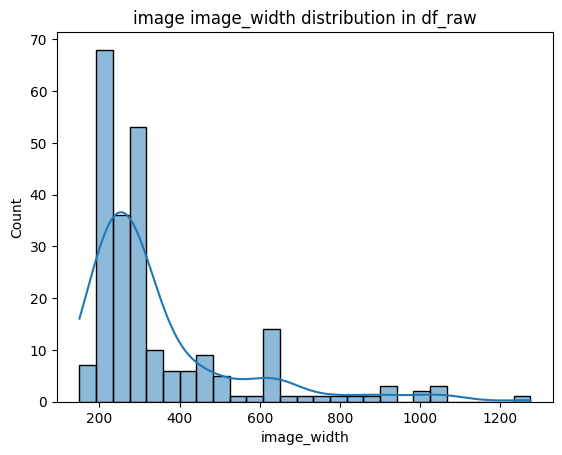

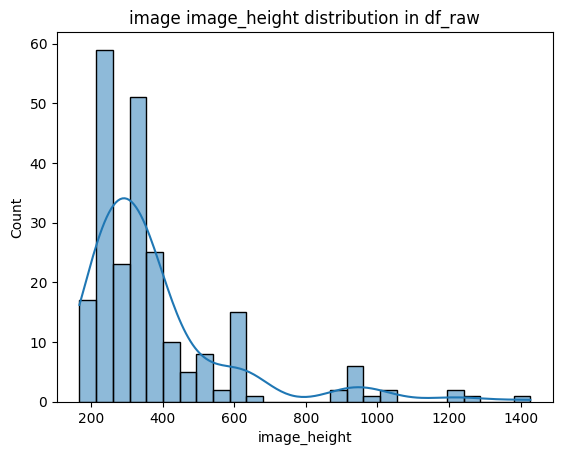

In [10]:
for column in ['image_width','image_height']:
    plt.figure()
    plt.title(f"image {column} distribution in df_raw")
    sns.histplot(data=df_raw, x=column, kde=True)

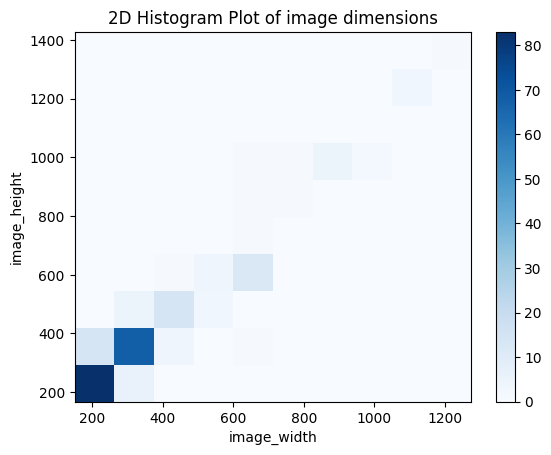

Highest Density Bin: (206.25, 230.95)


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data
x = df_raw['image_width']
y = df_raw['image_height']

# Create a 2D histogram plot
h, xedges, yedges, image = plt.hist2d(x, y, bins=10, cmap='Blues')

# Find the bin with the highest density
max_density_bin = np.unravel_index(np.argmax(h), h.shape)

# Get the x and y coordinates of the bin
x_coord = (xedges[max_density_bin[1]] + xedges[max_density_bin[1] + 1]) / 2
y_coord = (yedges[max_density_bin[0]] + yedges[max_density_bin[0] + 1]) / 2

# Plot the 2D histogram
plt.xlabel('image_width')
plt.ylabel('image_height')
plt.title('2D Histogram Plot of image dimensions')
plt.colorbar()
plt.show()

# Print the coordinates of the bin with the highest density
print(f"Highest Density Bin: ({x_coord}, {y_coord})")


#### MAYBE can use 206 width and 230 height cuz thats the majority size

### Visualise Raw Images

../Project/Brain_Tumor/data/malignant/62.jpg
(294, 250, 3) (294, 250)
../Project/Brain_Tumor/data/malignant/156.jpg
(370, 286, 3) (370, 286)
../Project/Brain_Tumor/data/malignant/180.jpg
(586, 467, 3) (586, 467)
../Project/Brain_Tumor/data/malignant/168.jpg
(300, 263, 3) (300, 263)
../Project/Brain_Tumor/data/malignant/105.jpg
(246, 205, 3) (246, 205)


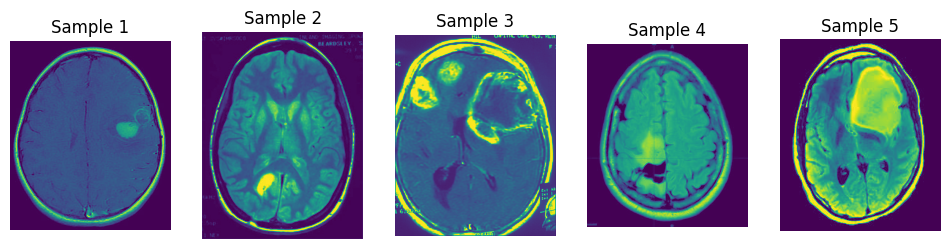

In [12]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your dataset
dataset_path = '../Project/Brain_Tumor/data'

# Define the class names
class_names = ['benign', 'malignant']

# Choose a class to display
class_to_display = 'malignant'
class_path = os.path.join(dataset_path, class_to_display)
sample_images = random.sample(os.listdir(class_path), 5)

# Display sample images
plt.figure(figsize=(12, 6))
for i, image_name in enumerate(sample_images):
    image_path = os.path.join(class_path, image_name)
    print(image_path)
    original_image = cv2.imread(image_path)
    gray_image = cv2.imread(image_path, 0)
    print(original_image.shape, gray_image.shape) #Although when u take in the images, it looks like its in grayscale; but its in RGB (3 channels)
    plt.subplot(1, 5, i + 1)
    plt.imshow(gray_image)
    plt.title(f'Sample {i + 1}')
    plt.axis('off')
plt.show()

## Denoising (remove annotations)

../Project/Brain_Tumor/data/malignant/30.jpg


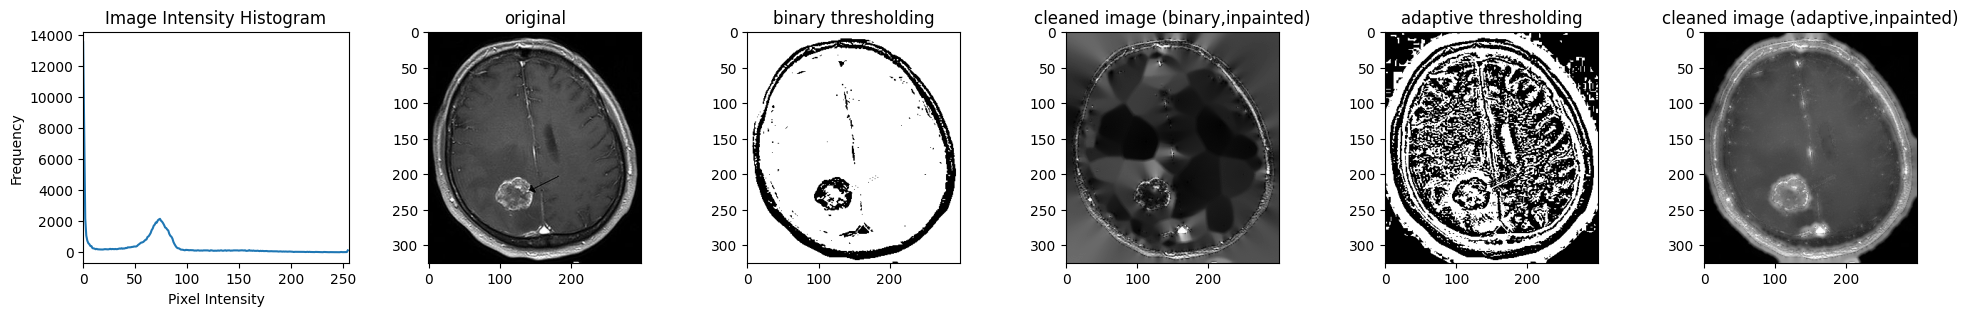

../Project/Brain_Tumor/data/malignant/38.jpg


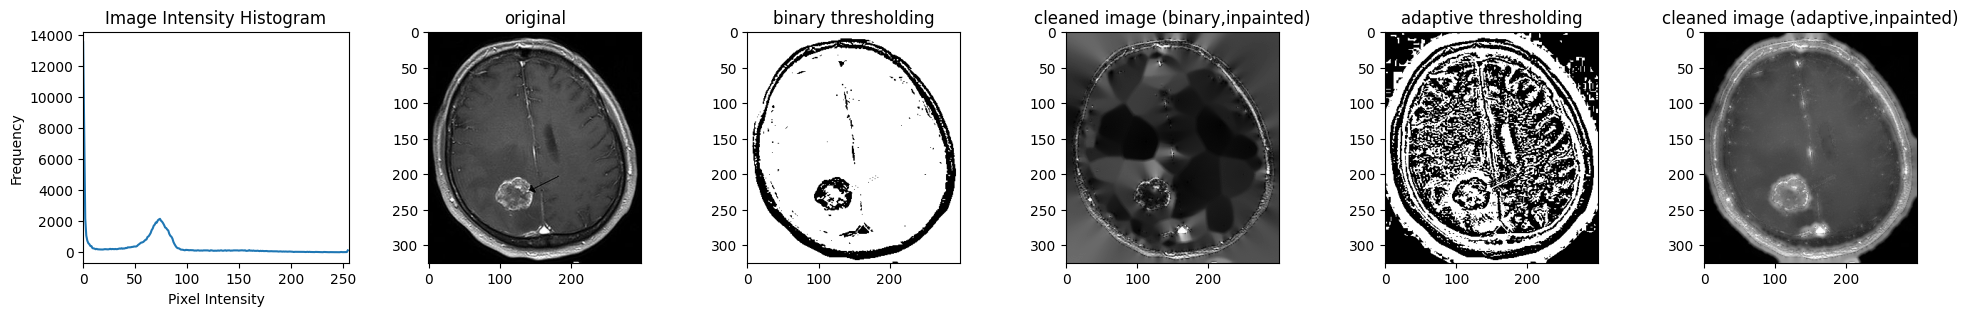

../Project/Brain_Tumor/data/malignant/54.jpg


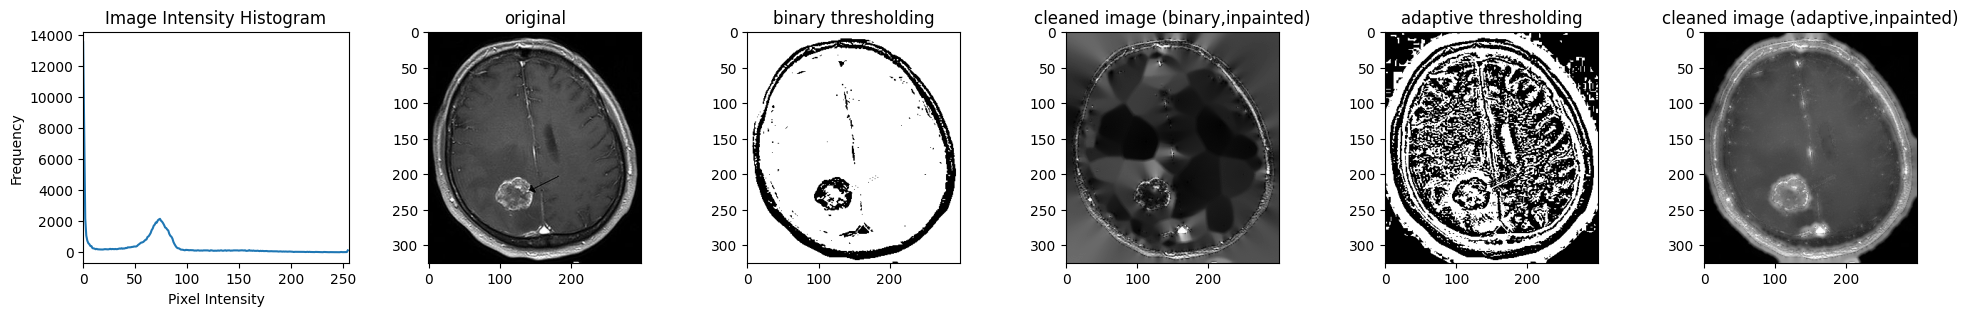

../Project/Brain_Tumor/data/malignant/70.jpg


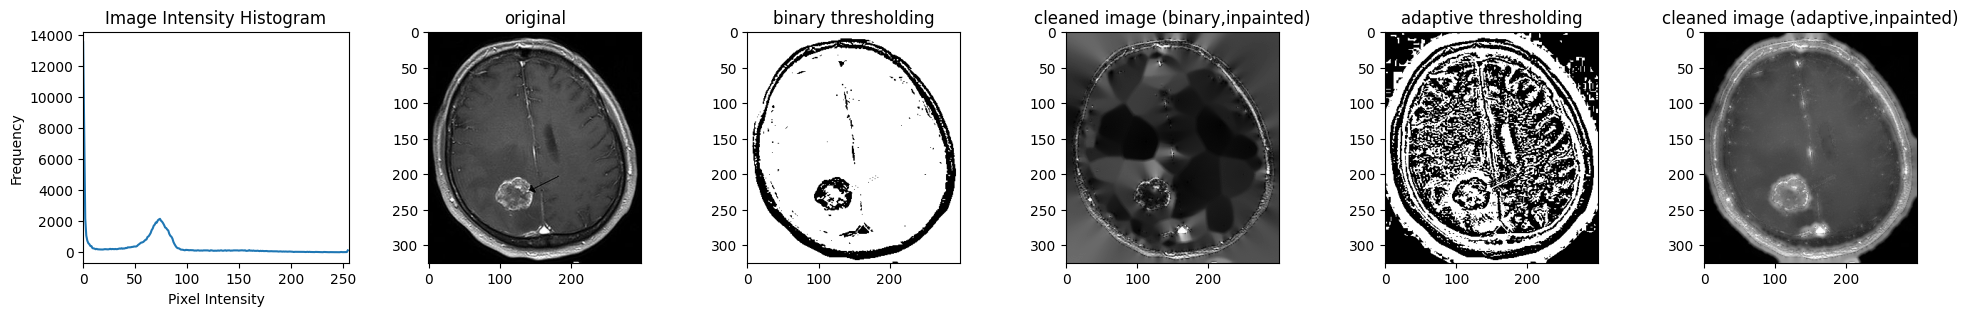

In [13]:
import os
import cv2
import matplotlib.pyplot as plt

def remove_noise(img_path):
    # Load image
    img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
    gray = img.copy()

    # Apply binary thresholding to obtain a binary mask of the black cross marks
    _, binary_mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
    adpative_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 1)

    # Apply inpainting to remove the black cross marks
    binary_inpaint = cv2.inpaint(img, binary_mask, 5, cv2.INPAINT_TELEA)
    adpative_inpaint = cv2.inpaint(img, adpative_mask, 5, cv2.INPAINT_TELEA)
    # Save the adpative_inpaint image back to the original image file
    cv2.imwrite(img_path, adpative_inpaint)
    
    plt.figure(figsize=(24,3))

    plt.subplot(1,6,1)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.plot(hist)
    plt.xlim([0, 256])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Image Intensity Histogram')

    plt.subplot(1,6,2)
    plt.title('original')
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1,6,3)
    plt.title('binary thresholding')
    plt.imshow(binary_mask, cmap='gray')

    plt.subplot(1,6,4)
    plt.title('cleaned image (binary,inpainted)')
    plt.imshow(binary_inpaint, cmap='gray')

    plt.subplot(1,6,5)
    plt.title('adaptive thresholding')
    plt.imshow(adpative_mask, cmap='gray')

    plt.subplot(1,6,6)
    plt.title('cleaned image (adaptive,inpainted)')
    plt.imshow(adpative_inpaint, cmap='gray')

    plt.show()

data_dir = "../Project/Brain_Tumor/data/malignant/"

# Define a list of selected images to process
selected_images = ['30.jpg', '38.jpg', '54.jpg', '70.jpg']  # Edit this list with your desired image filenames

for image in selected_images:
    image_path = os.path.join(data_dir, image)
    print(image_path)
    if os.path.exists(image_path):  # Check if the selected image exists in the current category folder
        remove_noise(image_path)


## Explore Blurring to reduce noise

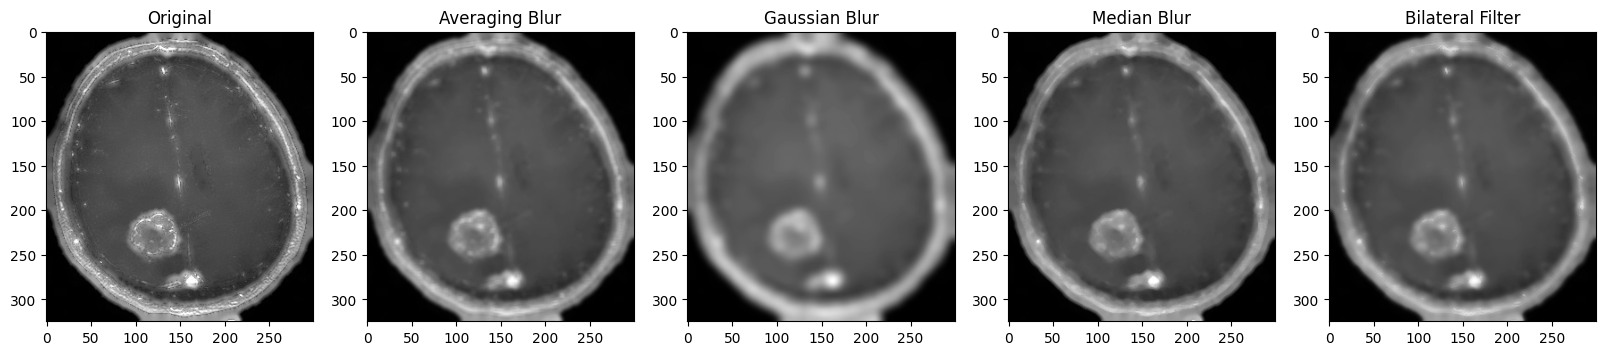

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_images(img1, img2, img3, img4, img5, titles):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,5,1)
    plt.imshow(img1, cmap='gray')
    plt.title(titles[0])
    
    plt.subplot(1,5,2)
    plt.imshow(img2, cmap='gray')
    plt.title(titles[1])
    
    plt.subplot(1,5,3)
    plt.imshow(img3, cmap='gray')
    plt.title(titles[2])

    plt.subplot(1,5,4)
    plt.imshow(img4, cmap='gray')
    plt.title(titles[3])

    plt.subplot(1,5,5)
    plt.imshow(img5, cmap='gray')
    plt.title(titles[4])
    
    plt.show()

# Load your image
img = cv2.imread('../Project/Brain_Tumor/data/malignant/30.jpg', 0)

# 1. Averaging Blur
avg_blur = cv2.blur(img, (5, 5))

# 2. Gaussian Blur
gaussian_blur = cv2.GaussianBlur(img, (15, 15), sigmaX=5, sigmaY=5, borderType=cv2.BORDER_DEFAULT)

# 3. Median Blur
median_blur = cv2.medianBlur(img, 5)

# 4. Bilateral Filter
bilateral_blur = cv2.bilateralFilter(img, 9, 75, 75)

# Your previous resizing method for reference
resized_blur = cv2.resize(img, (500, 500), interpolation=cv2.INTER_AREA)

# Plot images
plot_images(img, avg_blur, gaussian_blur, median_blur, bilateral_blur, titles=["Original", "Averaging Blur", "Gaussian Blur", "Median Blur", "Bilateral Filter"])


## 3 diff types of feature extractor: PCA, HOG and UMAP
#### extract the features as a form of vector, then feed it into traditional ML models

## 1. PCA

(231, 4096)


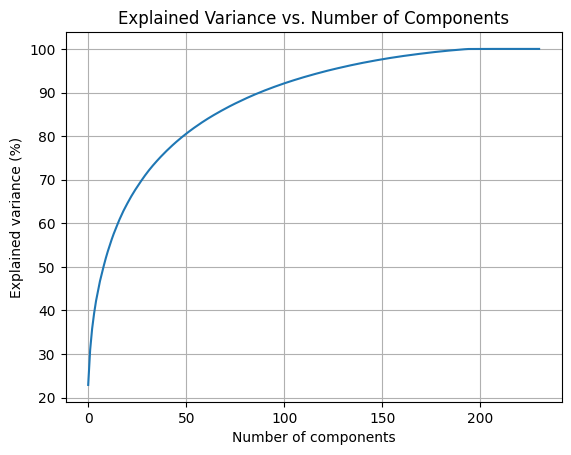

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA

# Define a function to load and preprocess images
def load_and_preprocess_images(directory, target_size=(64, 64)):
    images = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            if filepath.endswith(".jpg"):
                # Load image in grayscale
                img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                
                # Resize image to a standard size
                img = cv2.resize(img, target_size)
                
                # Flatten and append to the images list
                images.append(img.flatten())
    
    return np.array(images)

# Load and preprocess images from the specified directory
images_arr = load_and_preprocess_images("../Project/Brain_Tumor/data")
print(images_arr.shape) #231 rows means 231 total data, 64*64 image size for columns

# Perform PCA
pca = PCA(n_components=231) #231 cuz min of images_arr
pca.fit(images_arr)

# Plot the explained variance
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.title('Explained Variance vs. Number of Components')
plt.show()


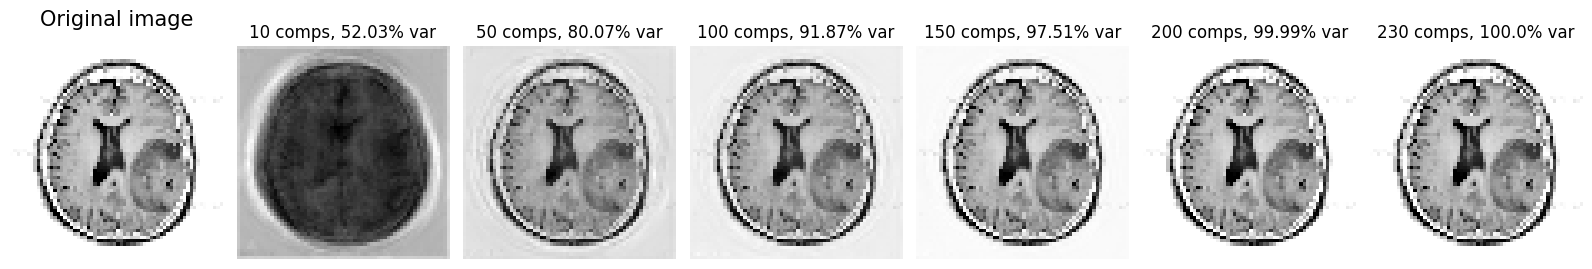

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# List of different dimensions (number of principal components) for PCA
dimensions = [10, 50, 100, 150, 200, 230]

# Select the second image from the dataset to visualize the effect of PCA
img = images_arr[1]
normalized_image = normalize_image(img)

# `normalized_image` are images that have been pre-processed to have pixel values between 0 and 1.
images = normalized_image

actual_image = normalized_image

# Reshape the flattened image to its original 2D shape
reshaped_actual_image = actual_image.reshape(64, 64)

# Create a grid of subplots with 1 row and 6 columns. This will be used to display the original and PCA-reconstructed images.
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16, 8))

# Display the reshaped original image in the first subplot
ax = axes[0]
ax.imshow(reshaped_actual_image, cmap='gray_r')
ax.set_title('Original image', fontsize=15, pad=15)
ax.axis('off')

# Iterate over the specified dimensions and perform PCA
for i, dim in enumerate(dimensions):
    
    # Perform PCA for the current number of components (dim)
    pca = PCA(n_components=dim)
    pca_reduced = pca.fit_transform(images_arr) # Reduce dimensionality
    # print(pca_reduced)
    pca_recovered = pca.inverse_transform(pca_reduced) # Reconstruct images from reduced dimensions

    # Reshape the PCA-reconstructed data to get the image format
    image_pca = pca_recovered[1,:].reshape([64, 64])
    
    # Display the PCA-reconstructed image
    ax = axes[i+1]  # Access the right subplot directly
    ax.imshow(image_pca, cmap='gray_r')
    
    # Calculate and display the cumulative explained variance by the PCA model
    var = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
    var = round(var, 2) # Round to two decimal places
    ax.set_title(f'{dim} comps, {var}% var', fontsize=12)
    ax.axis('off')


# Adjust the layout and padding of the plot for a better presentation
fig.tight_layout(pad=1.0)

# Show the plot
plt.show()


##### Based on the images, we can decide to use n_components = 150 because the % is close to 100% and the increase is not as much anymore

## 2. HOG

In [ ]:
# %pip install umap-learn
# %pip install scikit-image

(231, 4096)


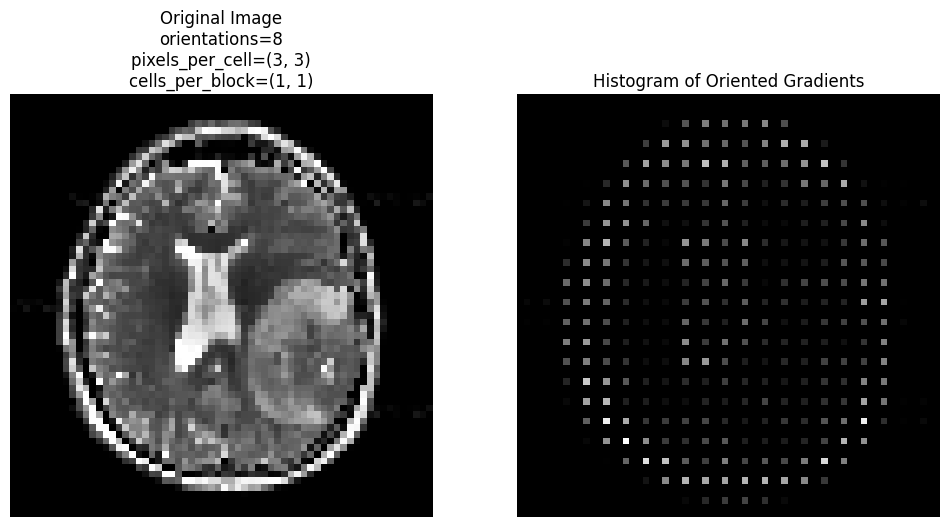

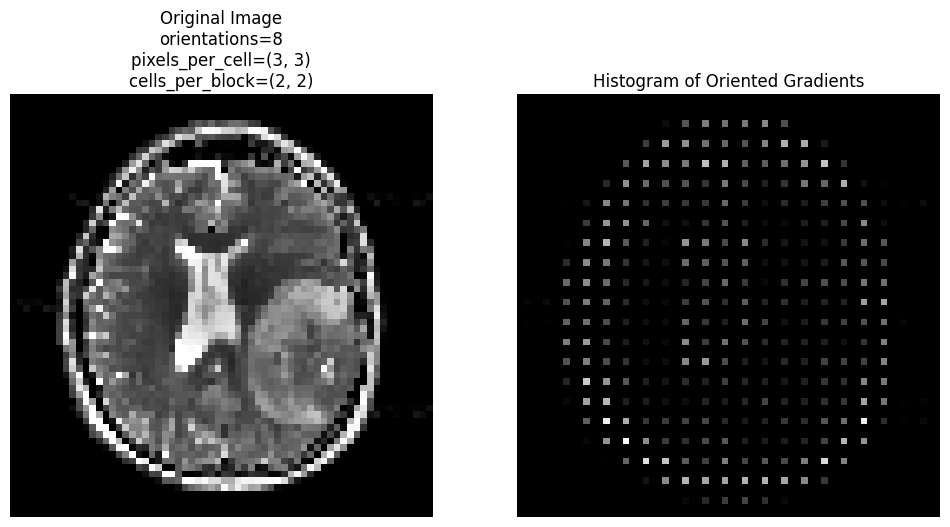

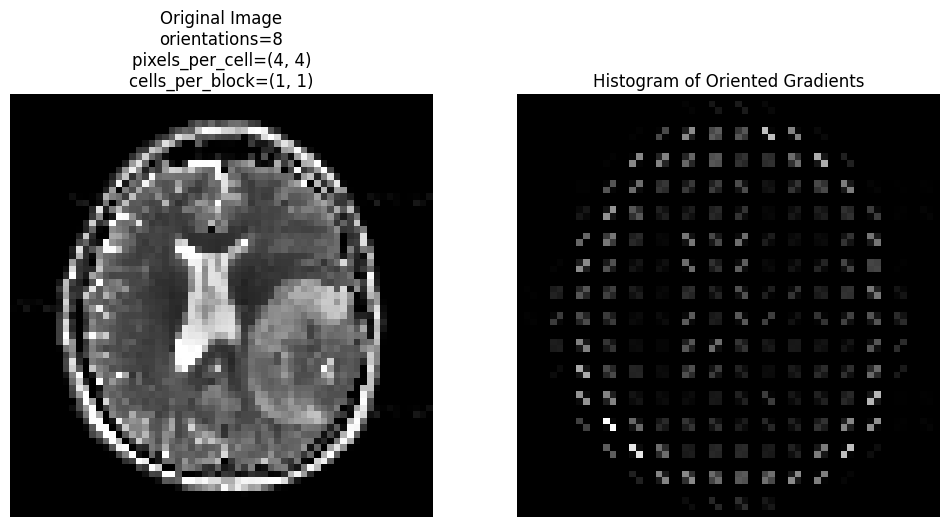

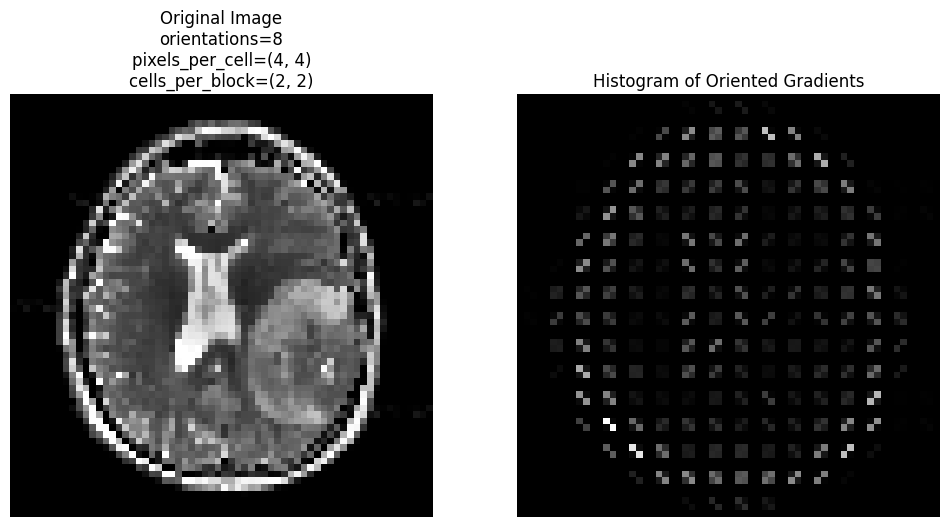

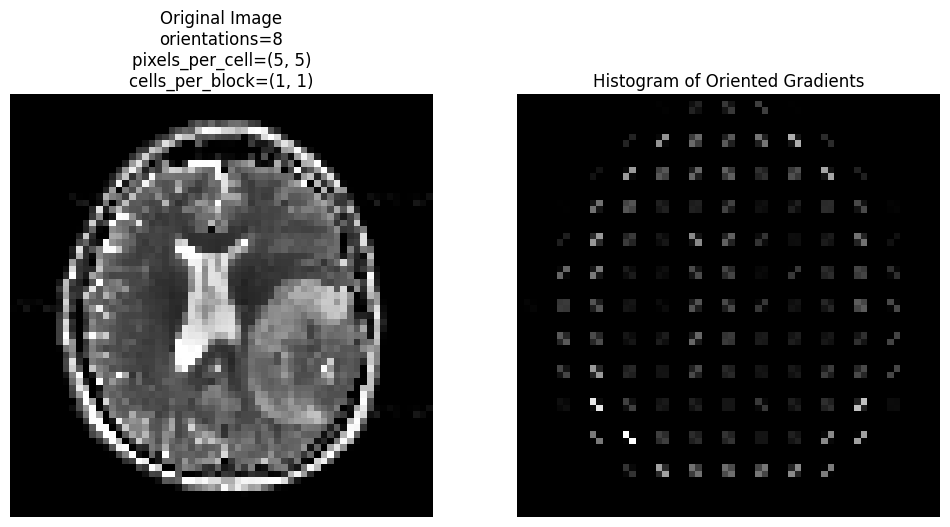

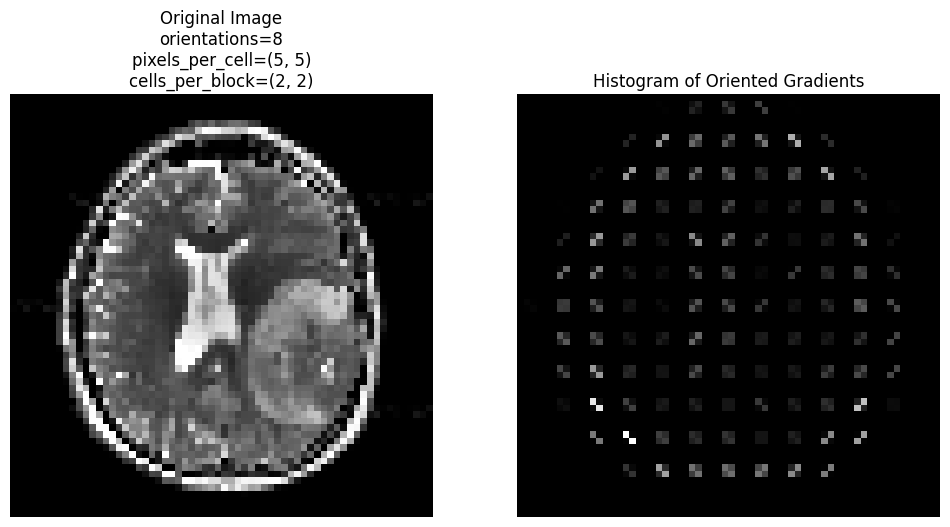

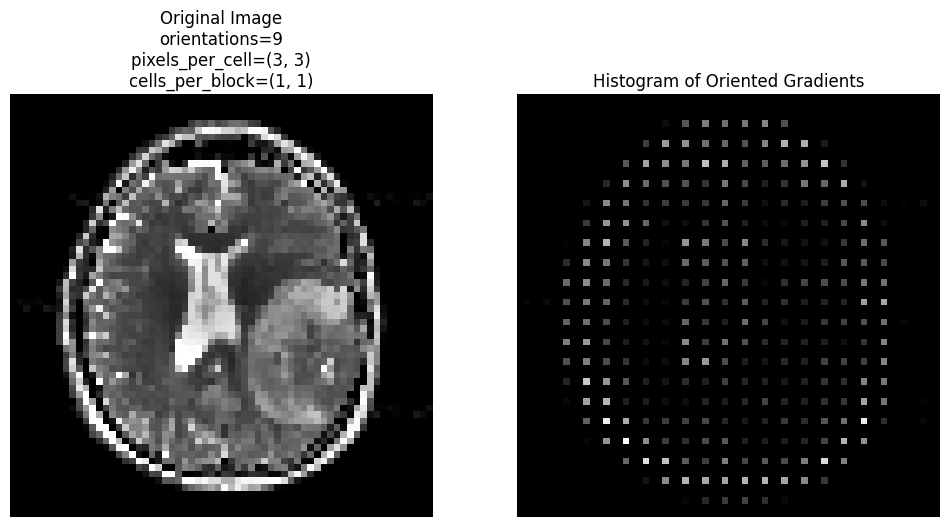

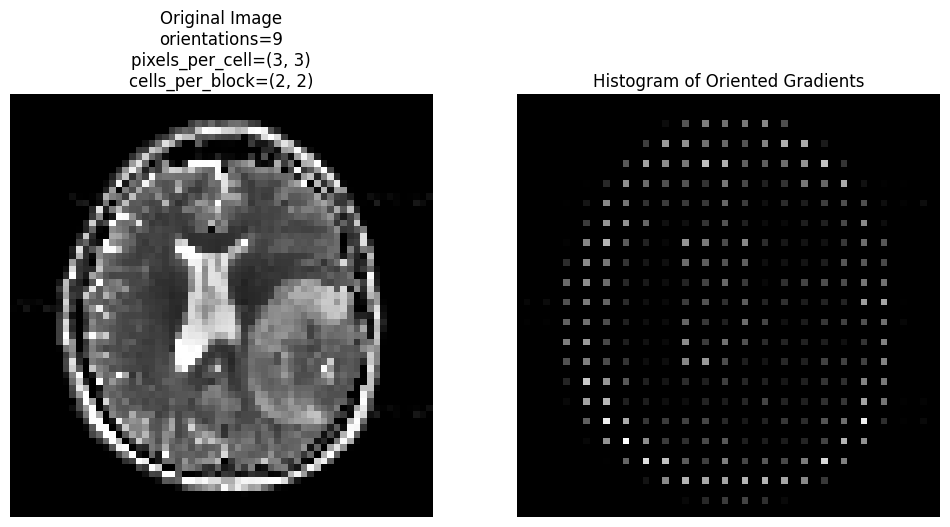

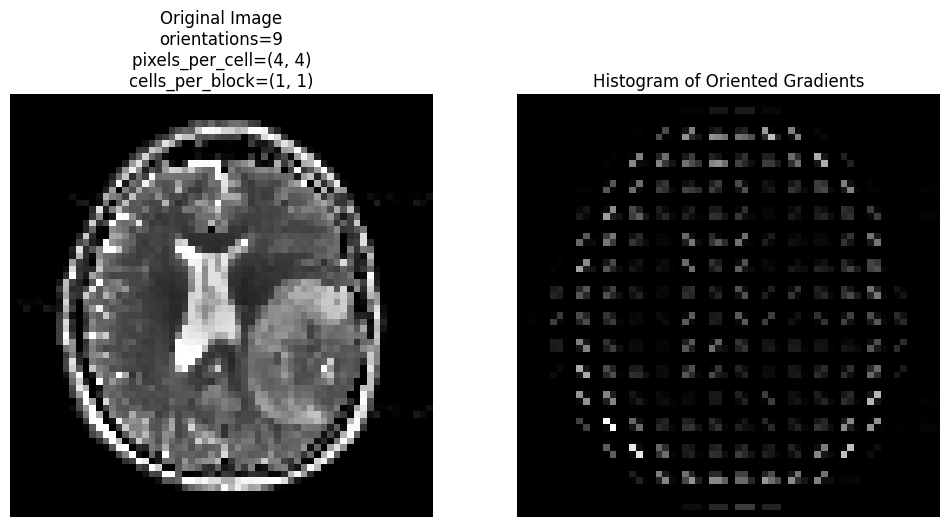

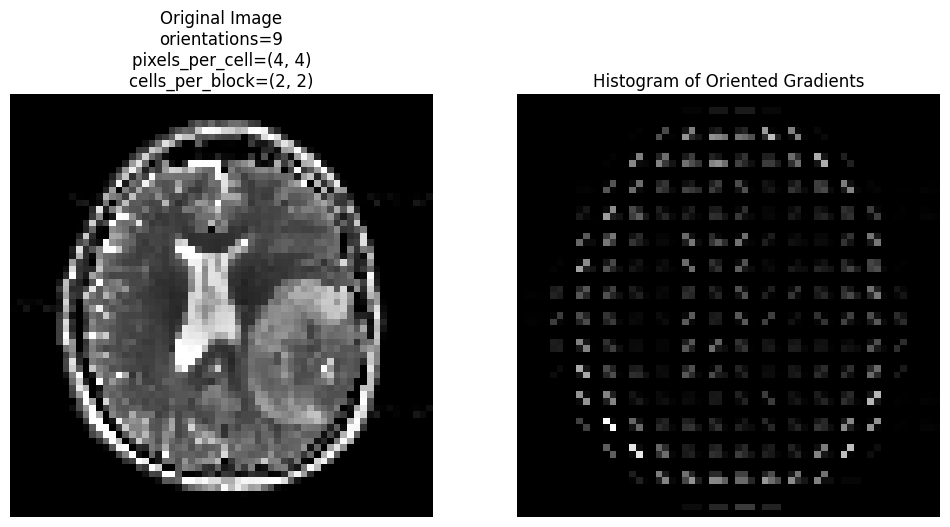

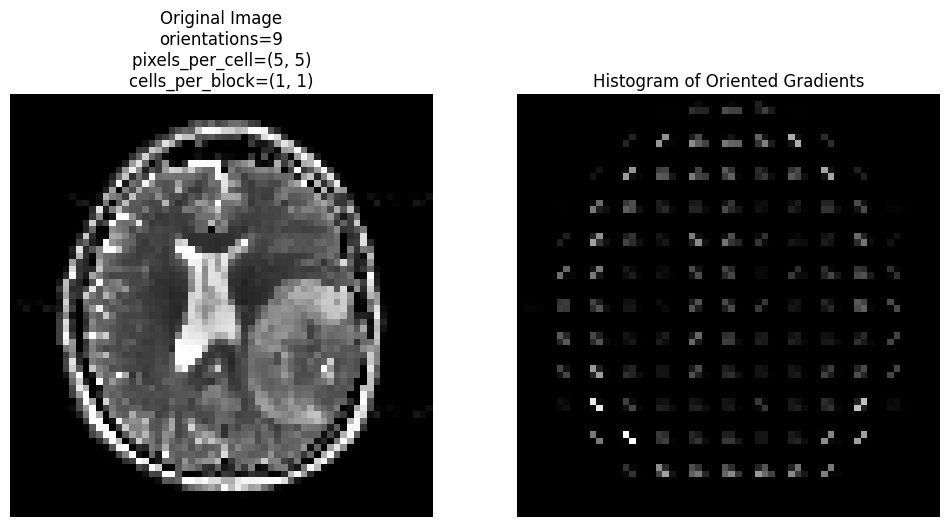

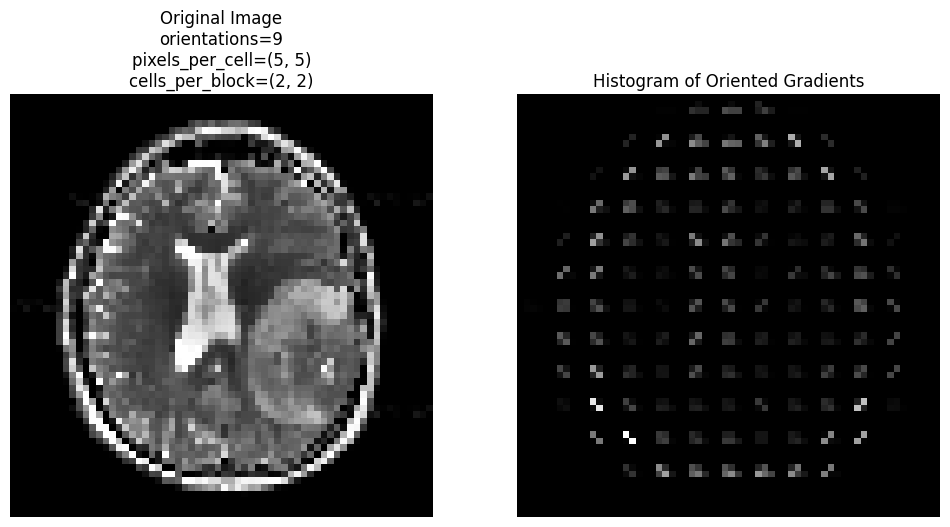

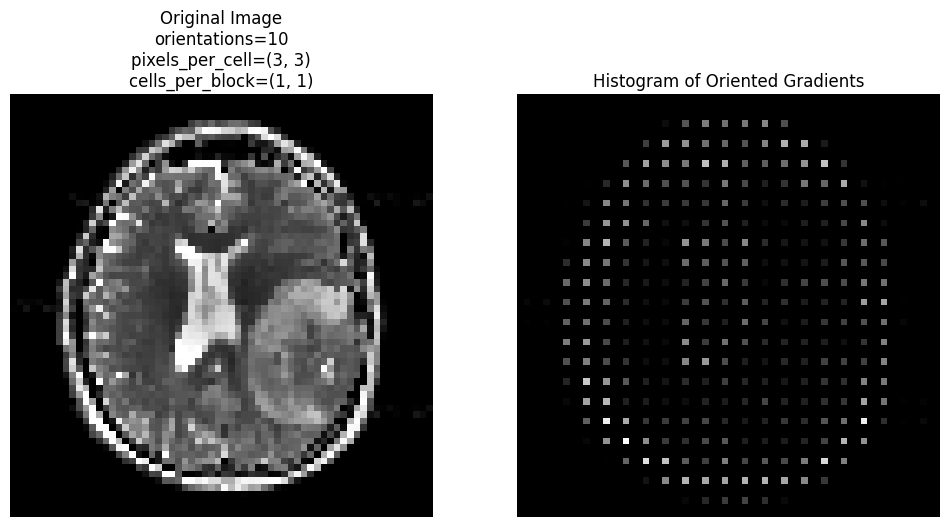

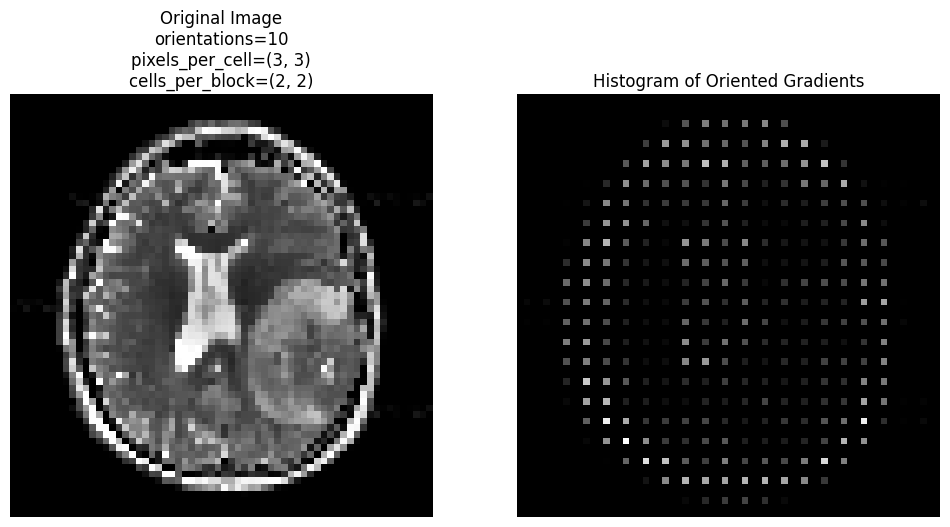

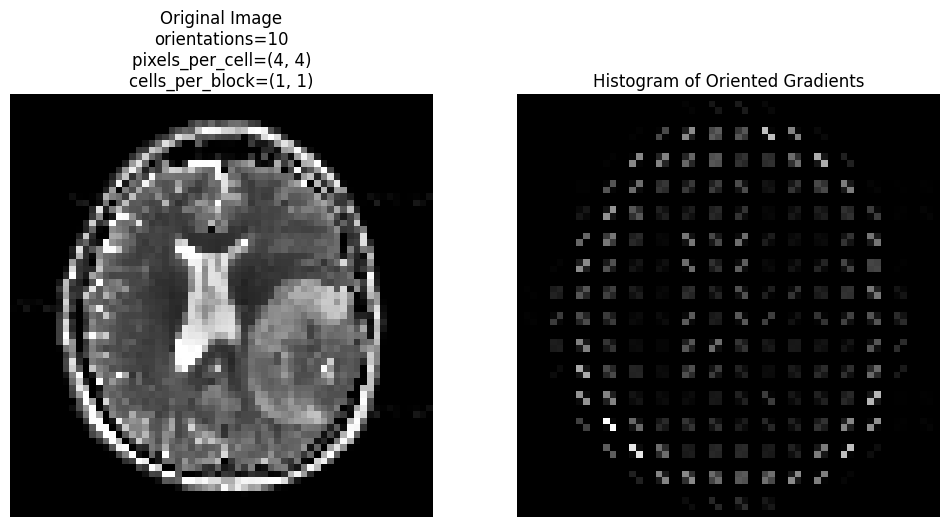

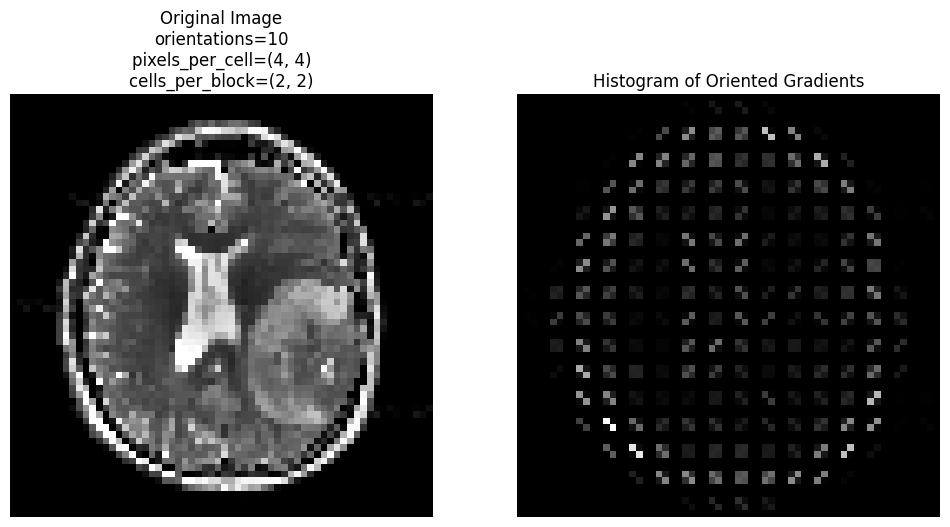

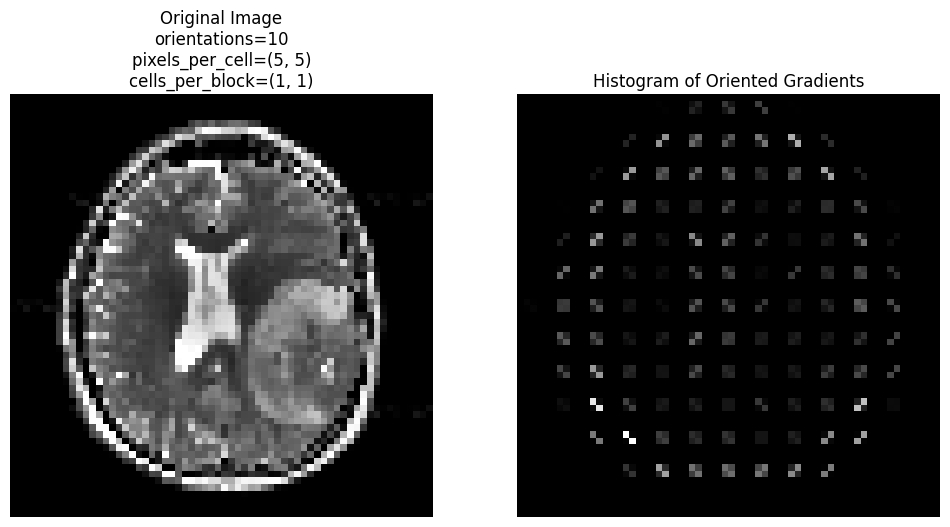

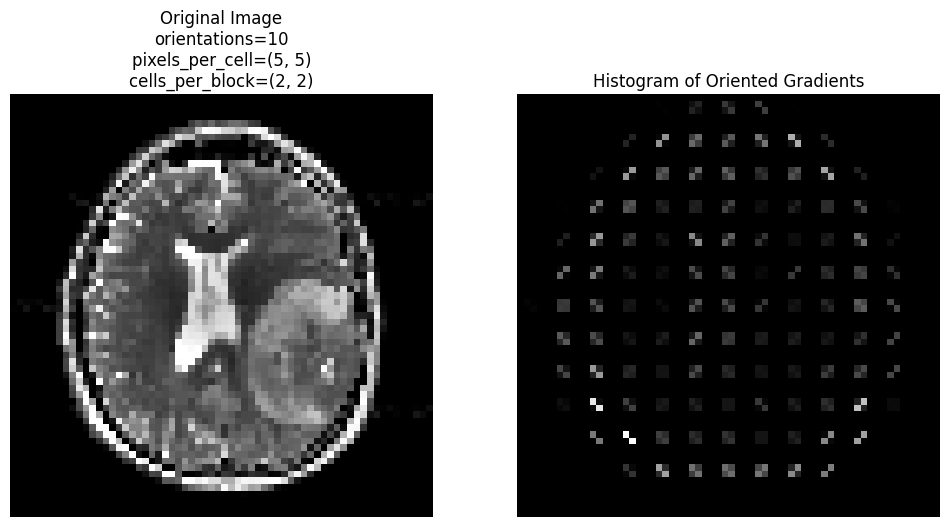

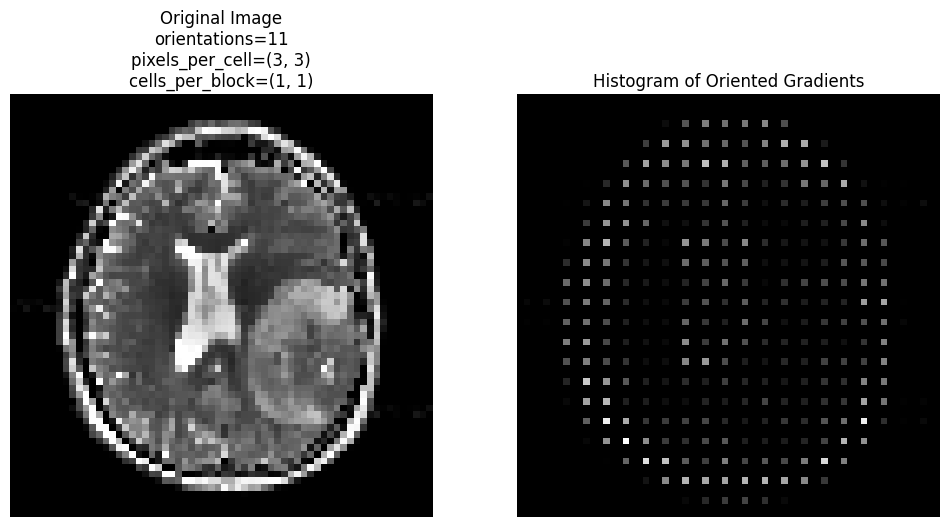

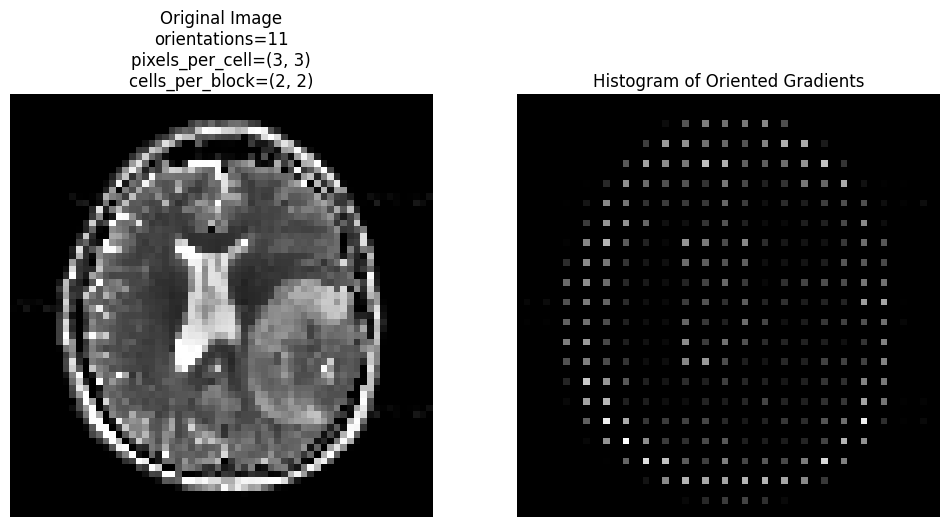

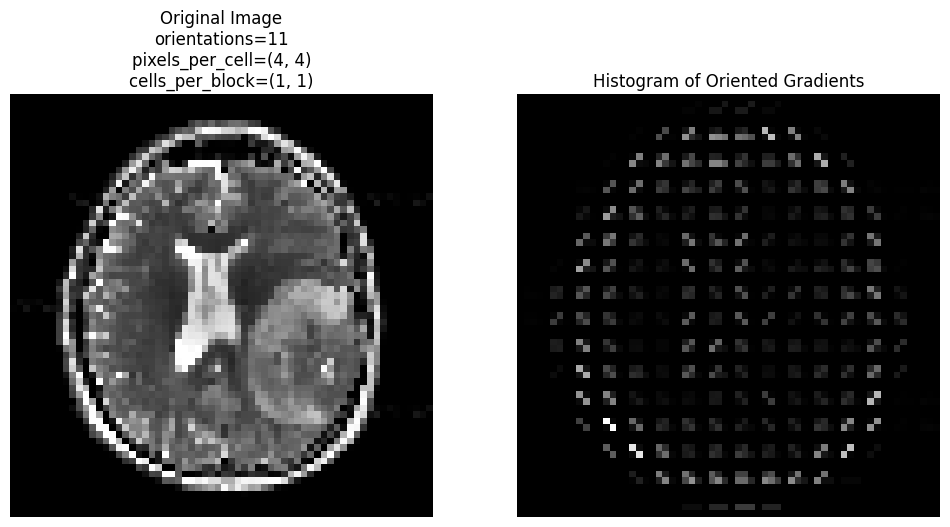

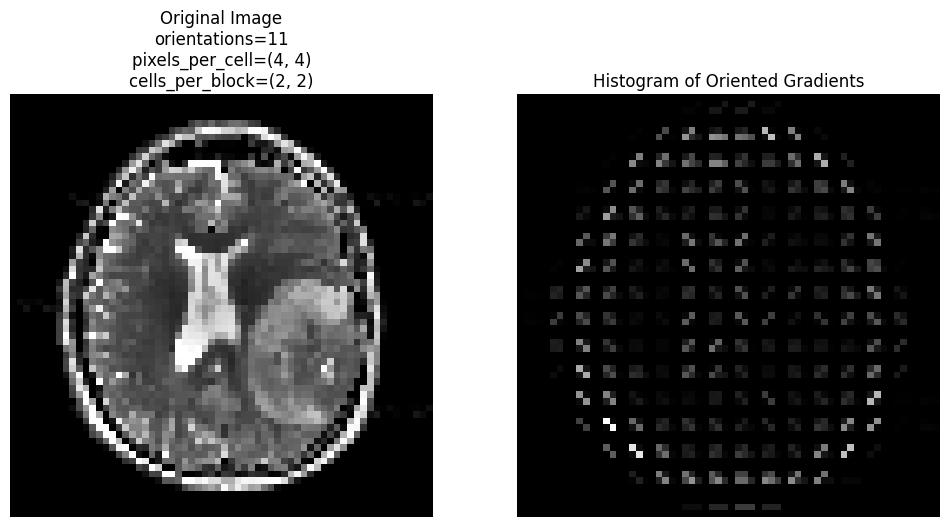

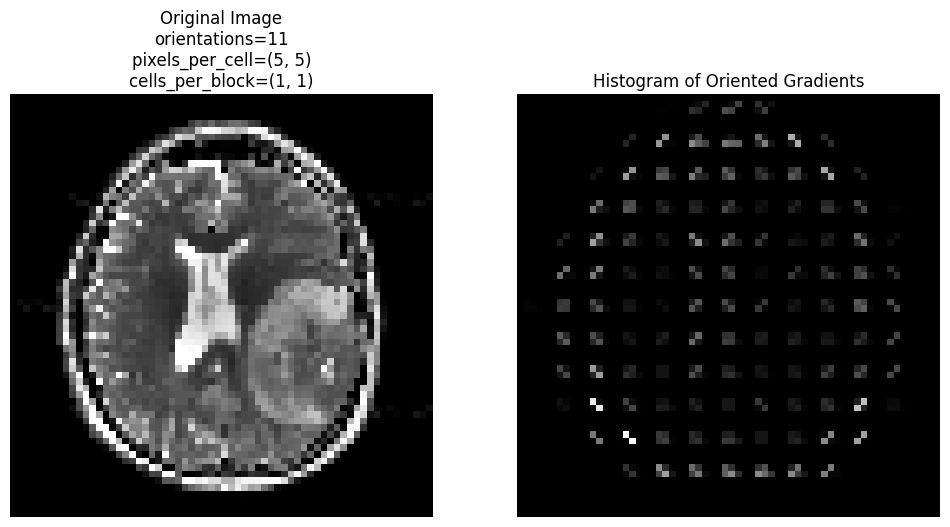

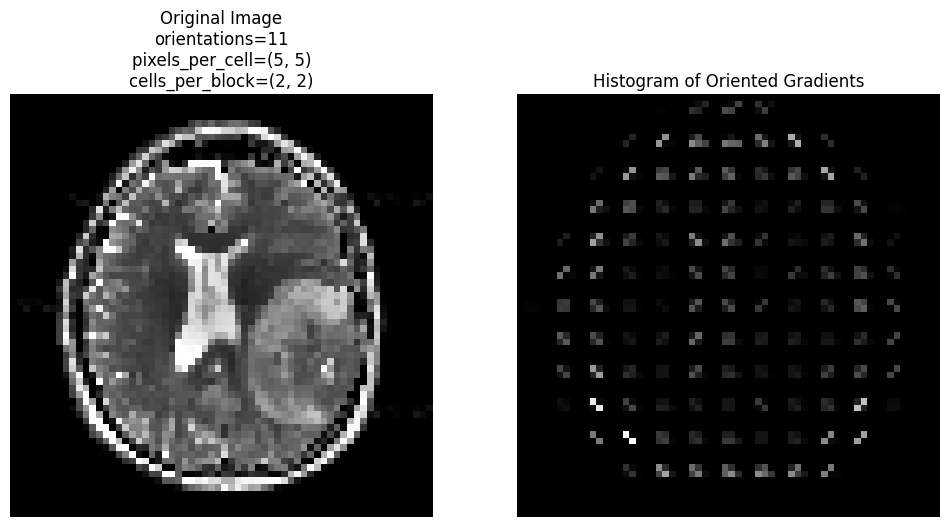

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA

# Define a function to load and preprocess images
def load_and_preprocess_images(directory, target_size=(64, 64)):
    images = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            if filepath.endswith(".jpg"):
                # Load image in grayscale
                img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                
                # Resize image to a standard size
                img = cv2.resize(img, target_size)
                
                # Flatten and append to the images list
                images.append(img.flatten())
    
    return np.array(images)

# Define a function to calculate HOG for given parameters
def calculate_hog(image, orientations, pixels_per_cell, cells_per_block):
    hog_features, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, visualize=True, block_norm="L2-Hys")
    return hog_features, hog_image

# Load and preprocess images from the specified directory
images_arr = load_and_preprocess_images("../Project/Brain_Tumor/data")
print(images_arr.shape)

# Set ranges for HOG parameters you'd like to try
orientations_range = [8, 9, 10, 11]
pixels_per_cell_range = [(3, 3), (4, 4), (5, 5)]
cells_per_block_range = [(1, 1), (2, 2)]

#select just one image
img = images_arr[1]
reshaped_image = img.reshape(64, 64) # Assuming target_size=(64, 64) from the loading function
for orientations in orientations_range:
    for pixels_per_cell in pixels_per_cell_range:
        for cells_per_block in cells_per_block_range:
            hog_features, hog_image = calculate_hog(reshaped_image, orientations, pixels_per_cell, cells_per_block)
            
            # Visualize the HOG image (or evaluate using some metric to find the best parameters)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

            ax1.axis('off')
            ax1.imshow(reshaped_image, cmap=plt.cm.gray)
            ax1.set_title(f'Original Image\norientations={orientations}\npixels_per_cell={pixels_per_cell}\ncells_per_block={cells_per_block}')

            ax2.axis('off')
            ax2.imshow(hog_image, cmap=plt.cm.gray)
            ax2.set_title('Histogram of Oriented Gradients')

            plt.show()



##### Based on qualitative image analysis, this feature extractor is unable to extract the tumor part. .: we should not use HOG as feature extractor

## 3. UMAP

/Users/zannlim/Desktop/Y4S1/IT1244/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-26 23:32:37.567943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


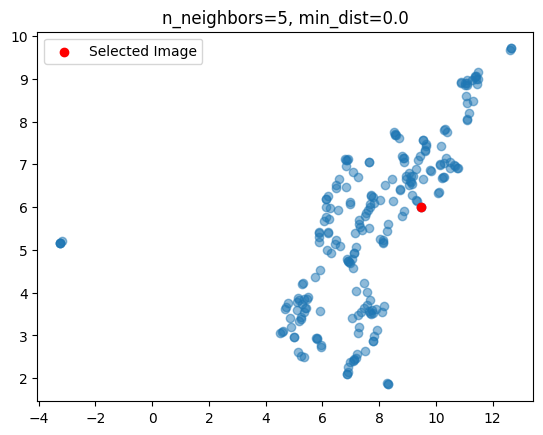

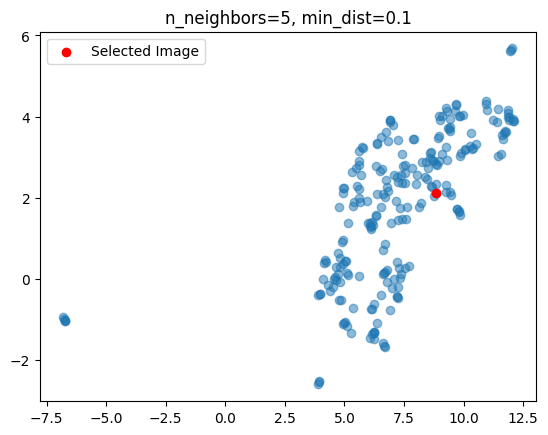

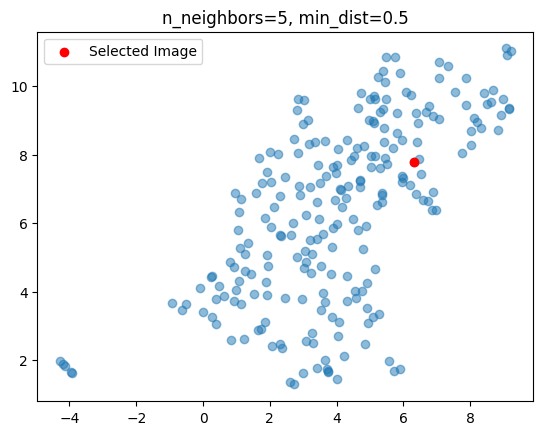

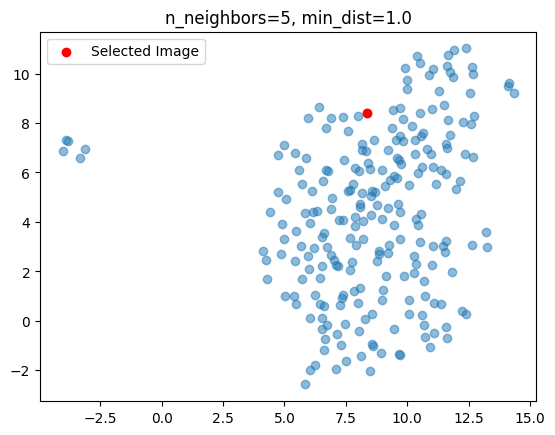

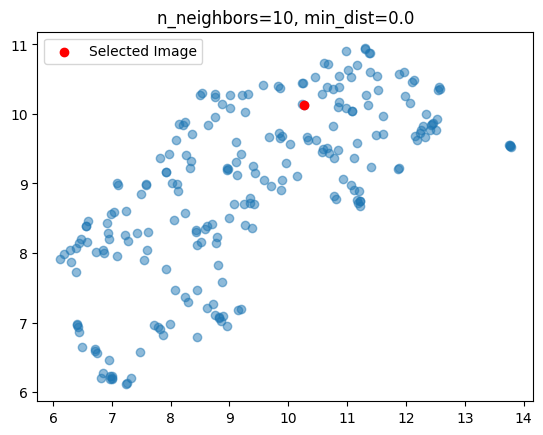

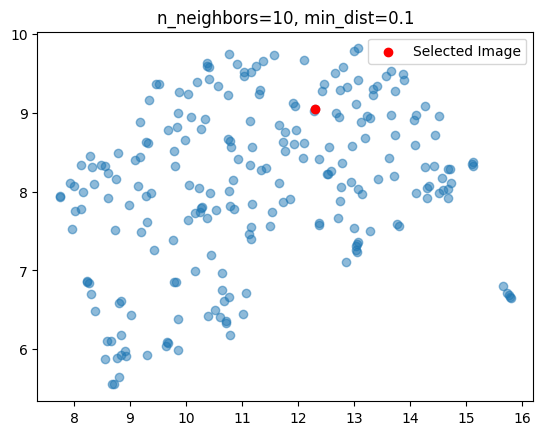

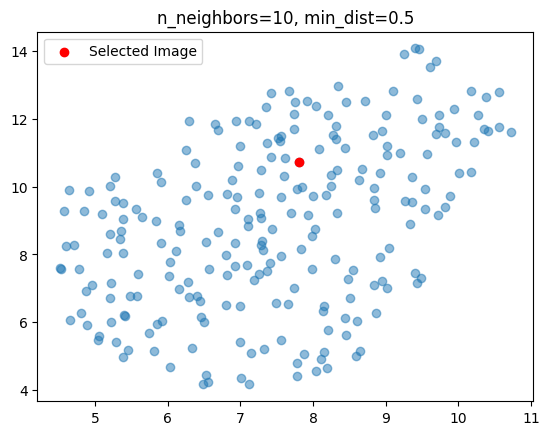

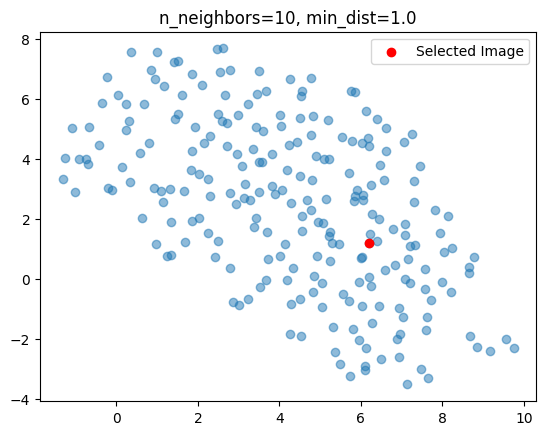

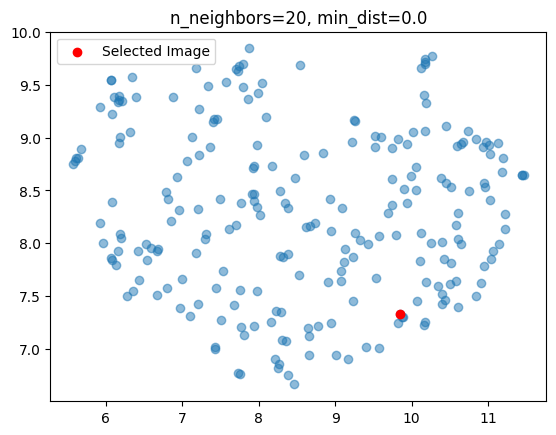

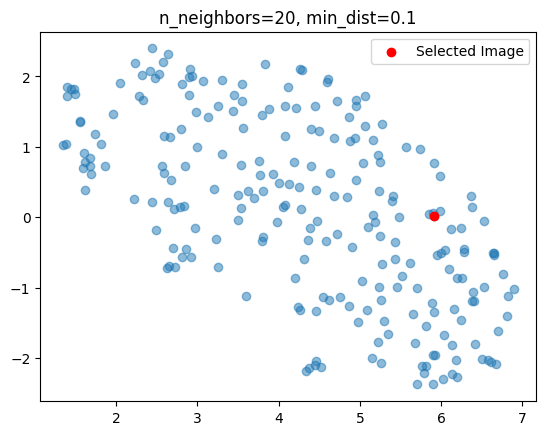

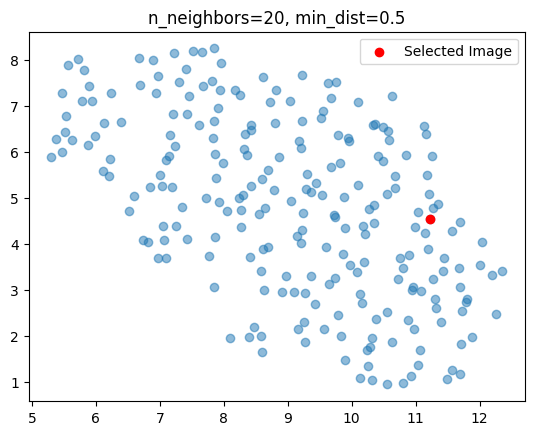

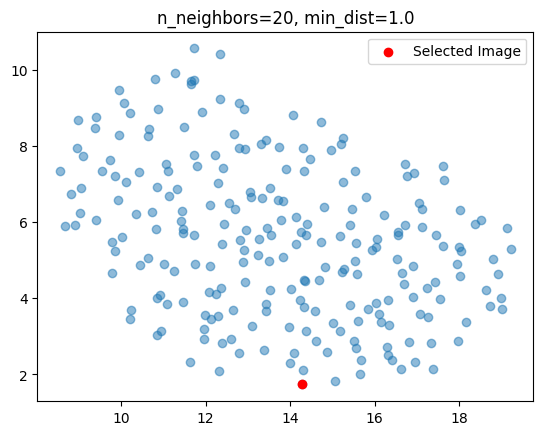

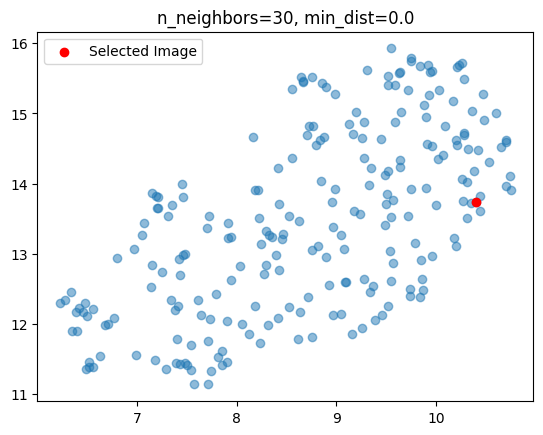

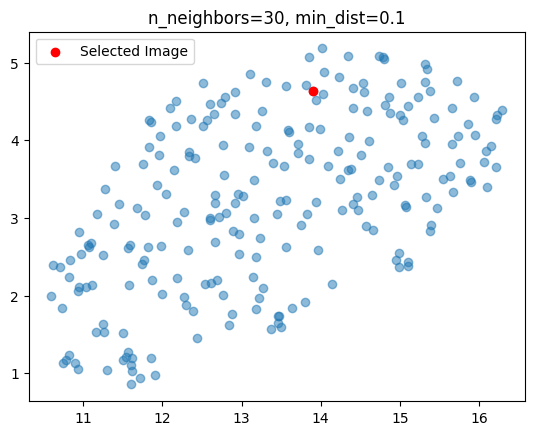

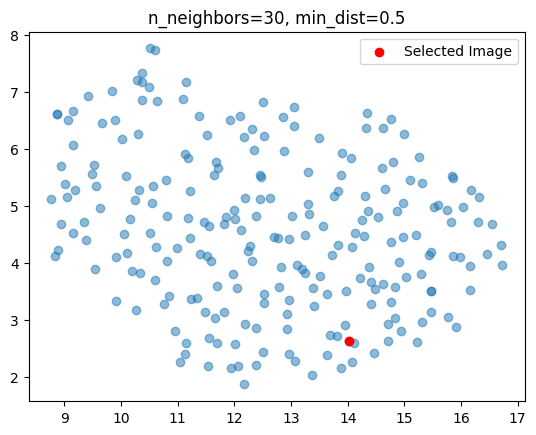

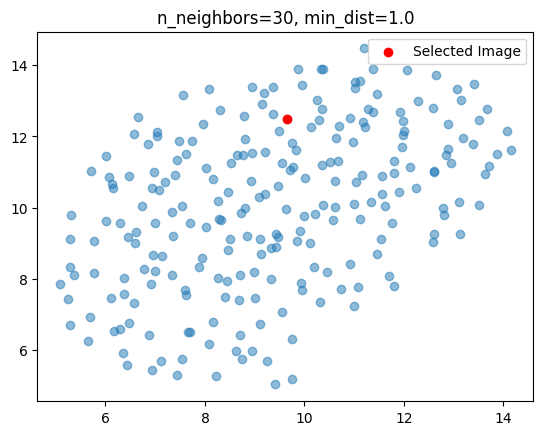

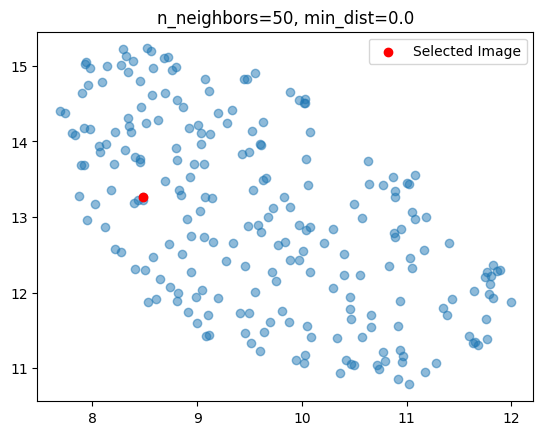

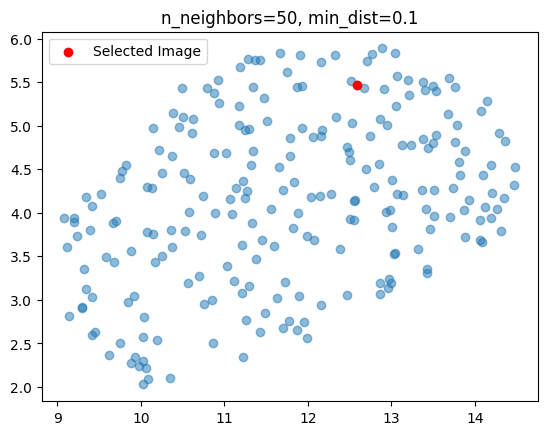

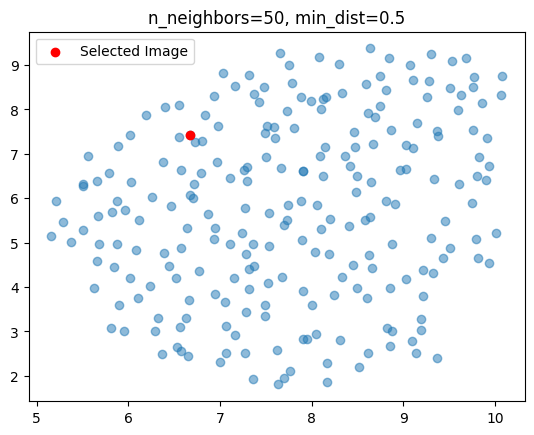

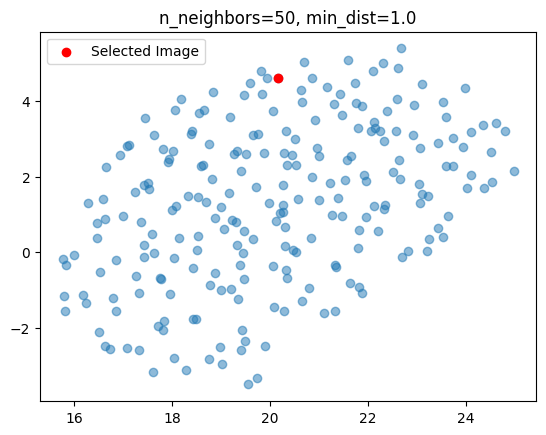

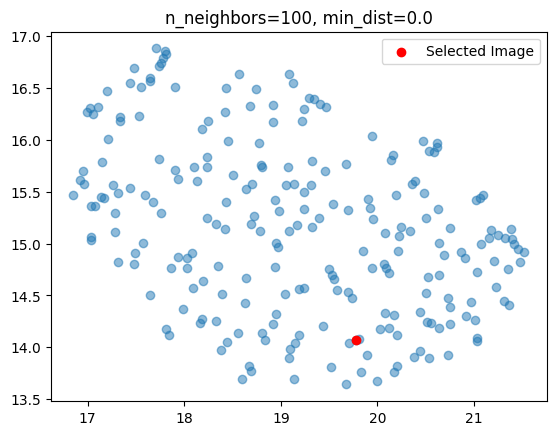

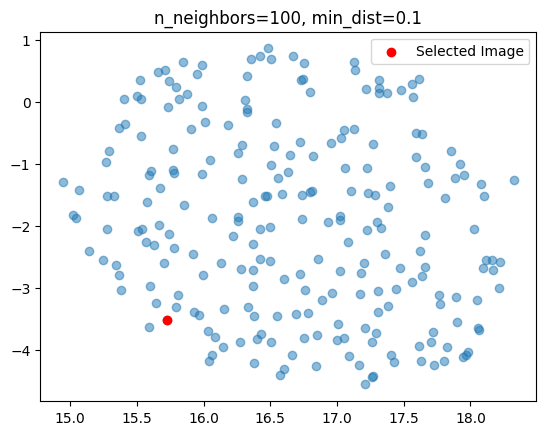

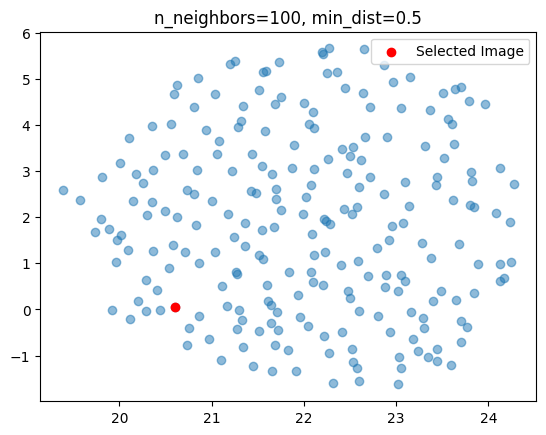

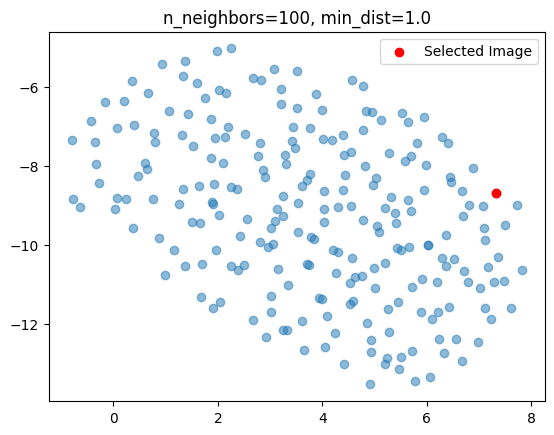

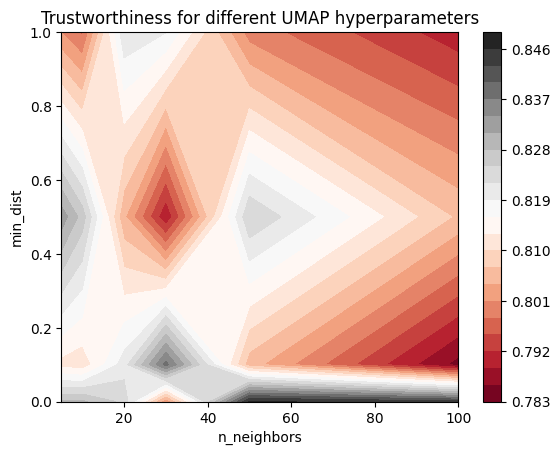

Best Parameters: n_neighbors=10, min_dist=0.0
Best Trustworthiness Score: 0.8466134762098887


In [18]:
import umap
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.manifold import trustworthiness

# Parameters to analyze
n_neighbors_list = [5, 10, 20, 30, 50, 100]
min_dist_list = [0.0, 0.1, 0.5, 1.0]

best_score = -1.0  # Initialize with a low score
best_params = None
trustworthiness_scores = []
# Calculate trustworthiness for different hyperparameters
for n_neighbors in n_neighbors_list:
    for min_dist in min_dist_list:
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2)
        embedding = reducer.fit_transform(images_arr)
        
        score = trustworthiness(images_arr, embedding)
        trustworthiness_scores.append(score)
        
        # Check if this combination has a higher score than the current best
        if score > best_score:
            best_score = score
            best_params = (n_neighbors, min_dist)
        
        # For visualization, plot the position of the second image in the 2D embedding
        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
        plt.scatter(embedding[1, 0], embedding[1, 1], color='red', label='Selected Image')
        plt.title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
        plt.legend()
        plt.show()

# Plot trustworthiness scores
X, Y = np.meshgrid(n_neighbors_list, min_dist_list)
Z = np.array(trustworthiness_scores).reshape(len(min_dist_list), len(n_neighbors_list))
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.title('Trustworthiness for different UMAP hyperparameters')
plt.xlabel('n_neighbors')
plt.ylabel('min_dist')
plt.show()

# Output the best parameters and score
print(f"Best Parameters: n_neighbors={best_params[0]}, min_dist={best_params[1]}")
print(f"Best Trustworthiness Score: {best_score}")

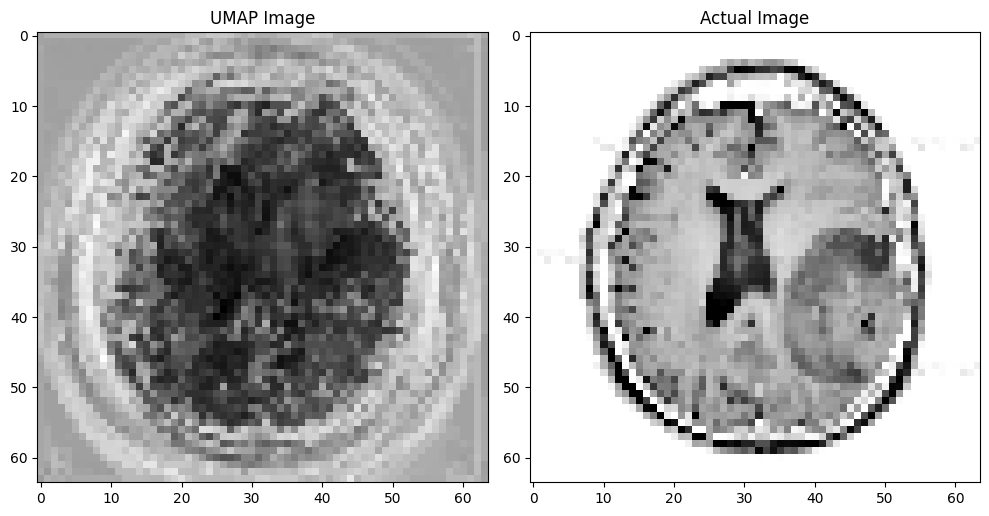

In [19]:
import umap
import matplotlib.pyplot as plt

# Initialize UMAP with inverse transform enabled
reducer = umap.UMAP(n_neighbors=10, min_dist=0.0)

# Fit the model and transform the data
embedding = reducer.fit_transform(images_arr)

# To get the approximate inverse transformation:
approximate_original = reducer.inverse_transform(embedding)
image_umap = approximate_original[1,:].reshape([64, 64])

# Assuming you have 'actual_image' defined somewhere in your code

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 'image_umap' in the first subplot
axes[0].imshow(image_umap, cmap='gray_r')
axes[0].set_title('UMAP Image')

# Plot 'actual_image' in the second subplot
axes[1].imshow(reshaped_actual_image, cmap='gray_r')
axes[1].set_title('Actual Image')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### CONCLUSION: Out of these 3 feature extractor, PCA is the best. So use PCA!

# 2. Train Test Split (Fixed Seed)

In [20]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

# Given paths from your code
main_folder_path = "../Project/Brain_Tumor/data"
benign_folder = os.path.join(main_folder_path, "benign_copy")
malignant_folder = os.path.join(main_folder_path, "malignant_copy")

# Paths for train and test directories
train_dir = os.path.join(main_folder_path, 'Train')
test_dir = os.path.join(main_folder_path, 'Test')

# Function to get all image files in a folder
def get_images_from_folder(folder_path):
    image_extensions = ["*.jpg", "*.jpeg", "*.png"]
    all_images = []
    
    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(folder_path, ext)))
        
    return all_images

# Split benign images
benign_images = get_images_from_folder(benign_folder)
benign_train, benign_test = train_test_split(benign_images, test_size=0.2, random_state=42)

# Split malignant images
malignant_images = get_images_from_folder(malignant_folder)
malignant_train, malignant_test = train_test_split(malignant_images, test_size=0.2, random_state=42)

# Copying images to their respective folders
def copy_images_to_folder(images, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for img in images:
        shutil.copy(img, target_folder)

# Creating Train and Test directories with benign and malignant subfolders
copy_images_to_folder(benign_train, os.path.join(train_dir, 'benign'))
copy_images_to_folder(benign_test, os.path.join(test_dir, 'benign'))
copy_images_to_folder(malignant_train, os.path.join(train_dir, 'malignant'))
copy_images_to_folder(malignant_test, os.path.join(test_dir, 'malignant'))

# Print the number of images in each set
print(f'Number of images in benign_train: {len(benign_train)}')
print(f'Number of images in benign_test: {len(benign_test)}')
print(f'Number of images in malignant_train: {len(malignant_train)}')
print(f'Number of images in malignant_test: {len(malignant_test)}')

Number of images in benign_train: 61
Number of images in benign_test: 16
Number of images in malignant_train: 123
Number of images in malignant_test: 31


## 3. Oversampling & Augmentation (Only apply to Training Set)

Oversampling is a technique commonly used in machine learning to address imbalanced datasets, where one class has significantly fewer samples than the other(s). In image classification, oversampling can be used to increase the number of samples in the minority class(es) to balance the dataset.

We first do a stratified train test split.

After that we do oversampling for the train set only. We do not apply data oversampling to the test set as it will result in data leakage.

In [ ]:
# %pip install tensorflow

In [21]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Initialize the data generator with your augmentations
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.5, 1.5],
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='uint8'
)

# Specify paths
benign_folder_path = '../Project/Brain_Tumor/data/Train/benign'
malignant_folder_path = '../Project/Brain_Tumor/data/Train/malignant'

# This function will perform the augmentation and save the augmented images
def augment_images_from_folder(folder_path, num_images_required):
    # List all the files in the folder
    files = os.listdir(folder_path)
    
    # Randomly choose 'num_images_required' images
    selected_files = random.sample(files, num_images_required)
    
    for filename in selected_files:
        img_path = os.path.join(folder_path, filename)
        
        # Load image
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate and save augmented images
        save_prefix = 'aug_' + os.path.splitext(filename)[0]  # Prefix for the new image
        save_path = folder_path  # Save back to the same folder
        
        # Create a generator from train_datagen.flow
        datagen_generator = train_datagen.flow(
            x,
            batch_size=1,  # Set batch_size to 1 to generate only 1 augmented image per original image.
            save_to_dir=save_path,
            save_prefix=save_prefix,
            save_format='jpeg'
        )
        
        # Iterate over the generator to perform augmentation and save the image
        for _ in range(1):  # You want to generate only one augmented image from one original image
            next(datagen_generator)

# Call the function for each folder
augment_images_from_folder(benign_folder_path, 61)
